In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import healpy as hp

from gaiaunlimited import utils
from gaiaunlimited.scanninglaw import GaiaScanningLaw

Author: Alfred Castro-Ginard

This notebook is to show how to estimate the Selection Function of a subsample of Gaia data. This subsample is constructed from a query to the Gaia archive, which counts the number of stars with or without a certain attribute. The result is binned in position (healpix index at a given level), magnitude and colour, which are the considered dependencies for the Selection Function.

The tutorial focuses on the specific case of the RVS (subsample with available radial velocity measuremets). However, it can be generalised to any subsample produced by a query on the archive (example queries are also provided at the end of the notebook).

## RVS subsample as a test case

### Using the GaiaUnlimited package

This section uses the build in function in the GaiaUnlimited python package. The function queries a precomputed table (stored in ~/.gaiaunlimited) generated from the Gaia archive. This table contains counts of stars with and without radial velocity measurements as a function of position (healpix level 5), magnitude (from G = 3 to G = 20 in steps of 0.2) and colour (from G-RP = -2.5 to G-RP = 5.1 in steps of 0.4).

In [3]:
# import relevant function from package

from gaiaunlimited.selectionfunctions import DR3RVSSelectionFunction

In [4]:
# iniitalize the selection function to be queried

dr3_rvs = DR3RVSSelectionFunction()

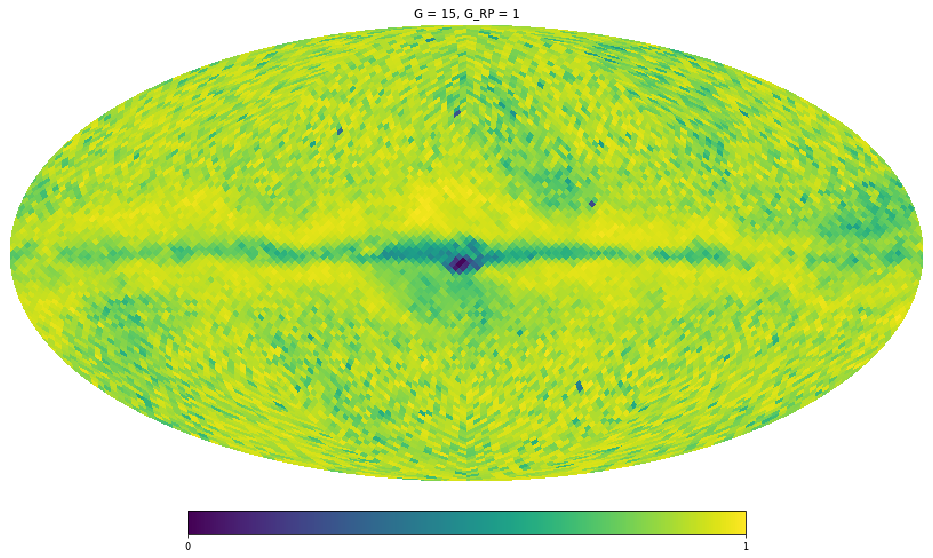

In [13]:
# query the SF all sky, at a given magnitude and colour

healpix_level = 5
G = 15
G_RP = 1

coords_of_centers = utils.get_healpix_centers(healpix_level)
gmag = np.ones_like(coords_of_centers) * G
col = np.ones_like(coords_of_centers) * G_RP

rvs_SF = dr3_rvs.query(coords_of_centers,g = gmag,c = col)

plt.figure(figsize = (20,10))
hp.mollview(rvs_SF,hold = True,min = 0,max = 1,title = 'G = {}, G_RP = {}'.format(G,G_RP))
plt.show()

### Get the Selection Function from a user table

This section focuses on what GaiaUnlimited does under the DR3RVSSelectionFunction. The tabulated data file can be replaced by a custom made table (see query examples at the end of the notebook)

In [16]:
# Read tabulated data file, and convert it to a pandas dataframe. 
# Also read the magnitudes and colour bins (provided with the file)

import h5py

filename = '~/.gaiaunlimited/dr3-rvs-nk.h5'

with h5py.File(filename, "r") as f:
    print(f.keys())
    c_bins = f['c_mid'][...]
    g_bins = f['g_mid'][...]
    data = f['data'][...]
    
data_df = pd.DataFrame.from_records(data)

<KeysViewHDF5 ['c_binsize', 'c_max', 'c_mid', 'c_min', 'data', 'g_binsize', 'g_max', 'g_mid', 'g_min', 'order']>


In [17]:
# Convert star counts to probabilities. 
# Assume a Beta-Binomial distribution with an uninformative prior 
# Check documentation on: https://gaiaunlimited.readthedocs.io/en/latest/dr3-rvs.html)

from scipy.special import logit

data_df['p'] = (data_df['k'] + 1)/(data_df['n'] + 2)
data_df['logitp'] = logit(data_df['p'])

In [18]:
# Convert to xarray to ease use

import xarray as xr

data_xa = xr.Dataset.from_dataframe(data_df.set_index(['ipix','i_g','i_c']))
data_xa = data_xa.assign_coords(i_g = g_bins,i_c = c_bins)
data_xa = data_xa.rename({'i_g':'g','i_c':'c'})

In [19]:
# Introduce desired healpix level, magnitude and colour to be queried

healpix_level
G = 15
G_RP = 1

ipix = utils.coord2healpix(coords_of_centers,'icrs',hp.order2nside(healpix_level))
ipix = xr.DataArray(np.atleast_1d(ipix))

factors = set(data_xa['logitp'].dims) - set({'ipix'})
d = {}
kwargs = {'g':np.ones_like(coords_of_centers) * G,'c':np.ones_like(coords_of_centers) * G_RP}
for i in factors:
    d[i] = xr.DataArray(np.atleast_1d(kwargs[i]))
d['method'] = 'nearest'
d['kwargs'] = dict(fill_value = None)

In [20]:
# Compute output and convert it to numpy

out = data_xa['logitp'].interp(ipix = ipix, **d).to_numpy()

In [21]:
# Provide result
# Note the use of the "logit" and "expit" functions to make it compatible with GaiaVerse's version

from scipy.special import expit

dr3_table = expit(out)

<Figure size 1440x720 with 0 Axes>

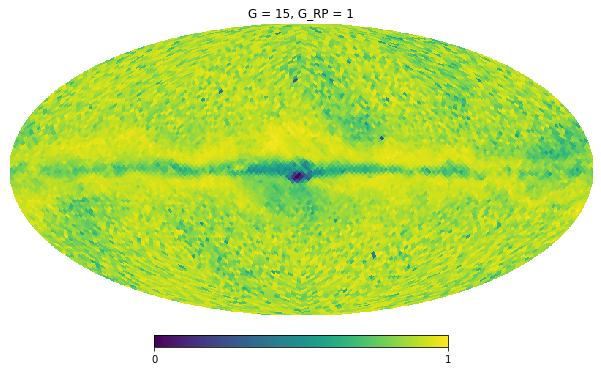

In [23]:
# Plot the results

plt.figure(figsize = (20,10))
hp.mollview(dr3_table,min = 0,max = 1,title = 'G = {}, G_RP = {}'.format(G,G_RP))
plt.show()

## Estimate the Selection Function from a queried subsample

This section focuses on generating the Selection Function from a custom made query on the Gaia archive. This functionality is currently under development and will soon be added to the GaiaUnlimited python package. 

In this example we focus on the sample of Gaia data with available teff_gspphot.

In [24]:
# query used to generate the table

query = """select magnitude, colour, position, count(*) as n, sum(selection) as k
            from (
                    select to_integer(floor((phot_g_mean_mag - 3)/0.2)) as magnitude,
                    to_integer(floor((g_rp + 2.5)/0.4)) as colour, 
                    to_integer(floor(source_id/562949953421312)) as position,
                    to_integer(IF_THEN_ELSE(teff_gspphot > 0, 1.0,0.0)) as selection
                from gaiadr3.gaia_source 
                where phot_g_mean_mag > 3 and phot_g_mean_mag < 20
                and g_rp > -2.5 and g_rp < 5.1
            ) as subquery
            group by magnitude, colour, position"""

In [25]:
# Read the downloaded data as a pandas dataframe

data_df = pd.read_csv('Gaia_teff_gspphot.csv')

In [28]:
# generate the bins in magnitude and colour

g_bins = np.arange(3.1,20,0.2)
c_bins = np.arange(-2.3,5.1,0.4)
print(g_bins.shape,c_bins.shape)

(85,) (19,)


<Figure size 1440x720 with 0 Axes>

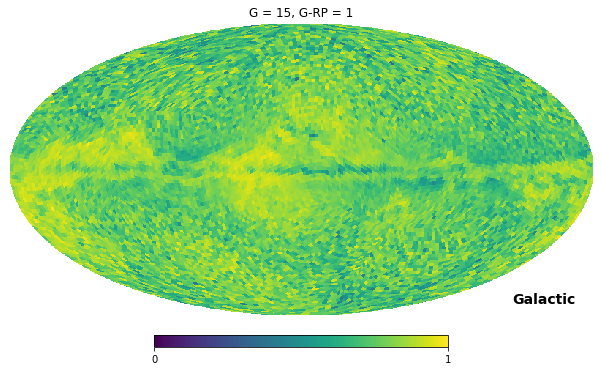

In [32]:
# run the same pieces of code than in the previous section

healpix_level = 5
G = 15
G_RP = 1

data_df['p'] = (data_df['k'] + 1)/(data_df['n'] + 2)
data_df['logitp'] = logit(data_df['p'])
data_xa = xr.Dataset.from_dataframe(data_df.rename(columns = {'position':'ipix','magnitude':'i_g','colour':'i_c'})\
                                      .set_index(['ipix','i_g','i_c']))
data_xa = data_xa.assign_coords(i_g = g_bins,i_c = c_bins)
data_xa = data_xa.rename({'i_g':'g','i_c':'c'})
ipix = utils.coord2healpix(coords_of_centers,'icrs',hp.order2nside(healpix_level))
ipix = xr.DataArray(np.atleast_1d(ipix))
factors = set(data_xa['logitp'].dims) - set({'ipix'})
d = {}
kwargs = {'g':np.ones_like(coords_of_centers) * G,'c':np.ones_like(coords_of_centers) * G_RP}
for i in factors:
    d[i] = xr.DataArray(np.atleast_1d(kwargs[i]))
d['method'] = 'nearest'
d['kwargs'] = dict(fill_value = None)
out = data_xa['logitp'].interp(ipix = ipix, **d).to_numpy()
dr3_ownTable = expit(out)

plt.figure(figsize = (20,10))
hp.mollview(dr3_ownTable,min = 0,max = 1,coord = 'CG',title = 'G = {}, G-RP = {}'.format(G,G_RP))
plt.show()